In [1]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2db

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error

In [4]:
def import_data():
 data = pd.read_csv('norway_new_car_sales_by_make.csv')
 
 data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
 
 df = pd.pivot_table(data=data,values='Quantity',index='Make',columns='Period',aggfunc='sum',fill_value=0)
 return df

In [5]:
def datasets(df, x_len=12, y_len=1, test_loops=12):
 D = df.values
 rows, periods = D.shape
 # Training set creation
 loops = periods + 1- x_len- y_len
 train = []
 for col in range(loops):
    train.append(D[:,col:col+x_len+y_len])
 
 train = np.vstack(train)
 print(train.shape)
 X_train, Y_train = np.split(train,[-y_len],axis=1)
 # Test set creation
 if test_loops > 0:
    X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)

    Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
 else: # No test set: X_test is used to generate the future forecast
    X_test = D[:,-x_len:]
    Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value
 # Formatting required for scikit-learn
 if y_len == 1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()
 return X_train, Y_train, X_test, Y_test

In [6]:
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
 df = pd.DataFrame(columns = ['MAE','RMSE','Bias'],index=['Train','Test'])
 df.index.name = name
 
 df.loc['Train','MAE'] = 100*np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train)

 df.loc['Train','RMSE'] = 100*np.sqrt(np.mean((Y_train-Y_train_pred)**2))/np.mean(Y_train)
 
 df.loc['Train','Bias'] = 100*np.mean((Y_train- Y_train_pred))/np.mean(Y_train)

 df.loc['Test','MAE'] = 100*np.mean(abs(Y_test- Y_test_pred))/np.mean(Y_test)
 
 df.loc['Test','RMSE'] = 100*np.sqrt(np.mean((Y_test-Y_test_pred)**2))/np.mean(Y_test)
 
 df.loc['Test','Bias'] = 100*np.mean((Y_test- Y_test_pred))/np.mean(Y_test)
 df = df.astype(float).round(1) #Round number for display
 print(df)

In [14]:
df = import_data()
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1,test_loops=12)

(7085, 13)


In [15]:
#Modification of data for LSTM
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

In [56]:
# Function to perform LSTM prediction

len_x = 12
num_layers = 4
# Create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(num_layers, input_shape=(1, len_x)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=2)
neurons = 500
model = Sequential()
model.add(Bidirectional(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# for ep in range(0,50):
#     model.fit(X_train, Y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
#     model.layers[0].reset_states()
model.fit(X_train, Y_train, epochs=200, batch_size=32, verbose=2, shuffle=False,validation_split=0.1)

Epoch 1/200


178/178 - 3497s - 20s/step - loss: 117453.7422 - val_loss: 151750.9531
Epoch 2/200
178/178 - 12s - 68ms/step - loss: 98558.3984 - val_loss: 133303.5938
Epoch 3/200
178/178 - 10s - 58ms/step - loss: 87015.7734 - val_loss: 121506.0312
Epoch 4/200
178/178 - 7s - 42ms/step - loss: 81224.6719 - val_loss: 115652.6797
Epoch 5/200
178/178 - 10s - 54ms/step - loss: 77942.3750 - val_loss: 111390.1719
Epoch 6/200
178/178 - 6s - 33ms/step - loss: 74871.7578 - val_loss: 107783.3906
Epoch 7/200
178/178 - 6s - 33ms/step - loss: 73027.4062 - val_loss: 105542.4375
Epoch 8/200
178/178 - 6s - 32ms/step - loss: 71427.8828 - val_loss: 103295.0234
Epoch 9/200
178/178 - 6s - 32ms/step - loss: 69964.3359 - val_loss: 102129.7031
Epoch 10/200
178/178 - 6s - 32ms/step - loss: 68519.7344 - val_loss: 100513.0625
Epoch 11/200
178/178 - 6s - 32ms/step - loss: 67890.3594 - val_loss: 100438.8438
Epoch 12/200
178/178 - 6s - 31ms/step - loss: 67289.3516 - val_loss: 98592.8125
Epoch 13/200
178/178 - 5s - 30ms/step - loss

In [53]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='LSTM basic')

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              MAE   RMSE  Bias
LSTM basic                    
Train       129.7  222.3  32.7
Test        124.7  218.5  39.9


<function matplotlib.pyplot.show(close=None, block=None)>

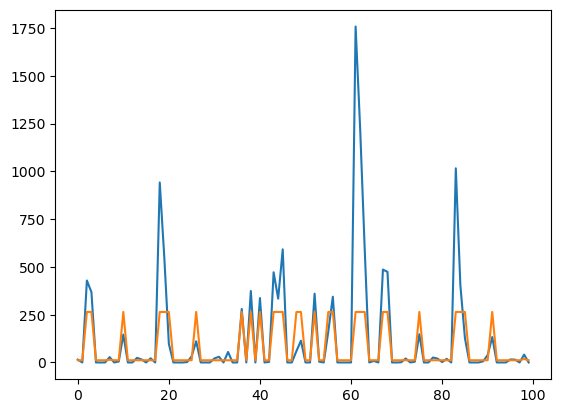

In [20]:
plt.plot(Y_train[:100])
plt.plot(Y_train_pred[:100])
plt.show

Epoch 1/100


C:\Users\prati\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


585/585 - 1s - 2ms/step - loss: 0.0447
Epoch 2/100
585/585 - 0s - 684us/step - loss: 0.0016
Epoch 3/100
585/585 - 0s - 663us/step - loss: 0.0012
Epoch 4/100
585/585 - 0s - 667us/step - loss: 0.0012
Epoch 5/100
585/585 - 0s - 665us/step - loss: 0.0011
Epoch 6/100
585/585 - 0s - 663us/step - loss: 9.8049e-04
Epoch 7/100
585/585 - 0s - 678us/step - loss: 8.9732e-04
Epoch 8/100
585/585 - 0s - 666us/step - loss: 7.8492e-04
Epoch 9/100
585/585 - 0s - 683us/step - loss: 7.3646e-04
Epoch 10/100
585/585 - 0s - 668us/step - loss: 7.0056e-04
Epoch 11/100
585/585 - 0s - 687us/step - loss: 6.4662e-04
Epoch 12/100
585/585 - 0s - 696us/step - loss: 6.3961e-04
Epoch 13/100
585/585 - 0s - 693us/step - loss: 6.0990e-04
Epoch 14/100
585/585 - 0s - 650us/step - loss: 5.8705e-04
Epoch 15/100
585/585 - 0s - 657us/step - loss: 5.7199e-04
Epoch 16/100
585/585 - 0s - 649us/step - loss: 5.1664e-04
Epoch 17/100
585/585 - 0s - 651us/step - loss: 5.5102e-04
Epoch 18/100
585/585 - 0s - 656us/step - loss: 5.1106e-04

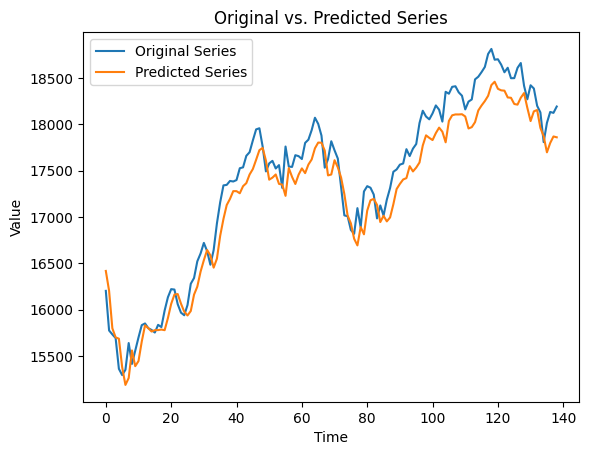

In [6]:
look_back = 12

# Perform LSTM prediction
predicted_series, original_series, testing_error = perform_LSTM(time_series_data, look_back)

# Print the testing error
print("Testing RMSE:", testing_error)

# Plot original vs. predicted series
import matplotlib.pyplot as plt

plt.plot(original_series.flatten(), label='Original Series')
plt.plot(predicted_series.flatten(), label='Predicted Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original vs. Predicted Series')
plt.legend()
plt.show()

In [1]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error

# Load the data
df = pd.read_csv("C:/Users/prati/Machine learning and Artificial intelligence/Project thesis/Codes/Models/nifty_50_data.csv", index_col='Date', parse_dates=True)

# Function to create dataset for LSTM
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Function to create LSTM model
def create_lstm_model(look_back, layer=4):
    model = Sequential()
    model.add(LSTM(layer, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Function to perform LSTM prediction
def perform_LSTM(dataset, look_back, layer=4, epochs=100, batch_size=1):
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    
    # Normalize the data
    scaler = MinMaxScaler()
    dataset = scaler.fit_transform(dataset)
    
    # Split data into training and testing set
    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:, :]
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # Create and fit the LSTM network
    model = create_lstm_model(look_back, layer)
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    testing_error = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

    return testPredict, testY, testing_error

# Load time series data
time_series_data = df['Close'].values.reshape(-1, 1)

# Hyperparameters
look_back_values = [10, 20, 30]
layer_values = [4, 8, 16]
epochs_values = [50, 100, 150]
batch_size_values = [1, 16, 32]

# Perform grid search
param_grid = dict(look_back=look_back_values, layer=layer_values, epochs=epochs_values, batch_size=batch_size_values)
lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)
grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(time_series_data, look_back=10)  # Set default look_back to 10 for the grid search

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
